In [1]:
import keras 
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LeakyReLU, Input, Lambda, Concatenate, Dropout
from keras.losses import mean_absolute_error, mean_squared_error
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras import optimizers
from keras import metrics
import scipy.io
import tensorflow as tf
import keras.backend as K
from IPython.display import clear_output
import math

Using TensorFlow backend.


In [2]:
def transformMatrix(theta, d, a, alpha):
    return np.array([[np.cos(theta), -np.sin(theta)*np.cos(alpha), np.sin(theta)*np.sin(alpha), a*np.cos(theta)], 
                     [np.sin(theta), np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)], 
                     [0, np.sin(alpha), np.cos(alpha), d], 
                     [0, 0, 0, 1]])

In [3]:
def forwardKinematics_1(theta1):
    T00 = transformMatrix(theta1,0,1,0)
    pos = [0, 0, 0, 1]
    Etip = np.matmul(T00,pos)
    return T00, Etip

In [4]:
def forwardKinematics_2(theta1, theta2):
    T00 = transformMatrix(theta1,0,1,0)
    T01 = transformMatrix(theta2,0,1,0)
    pos = [0, 0, 0, 1]
    Etip = np.matmul(np.matmul(T00, T01), pos)
    return T00, T01, Etip

In [5]:
def forwardKinematics_3(theta1, theta2, theta3):
    T00 = transformMatrix(theta1,0,1,0)
    T01 = transformMatrix(theta2,0,1,0)
    T02 = transformMatrix(theta3,0,1,0)
    pos = [0, 0, 0, 1]
    Etip = np.matmul(np.matmul(np.matmul(T00, T01), T02), pos)
    return T00, T01, T02, Etip

In [6]:
def get_positions_1(theta):
    # assuming theta is already in radian
    theta1 = theta[0]
    T00, Etip = forwardKinematics_1(theta1)
    return np.array(np.reshape(Etip[:2],(2,1)))

In [7]:
def get_positions_2(theta):
    # assuming theta is already in radian
    theta1 = theta[0]
    theta2 = theta[1]
    
    T00, T01, Etip = forwardKinematics_2(theta1, theta2)
    t = np.transpose(np.array([[0, 0, 0, 1]]))
    pos_1 = np.matmul(T00, t)
    
    # only return first 2 elements
    return np.array([pos_1[:2], np.reshape(Etip[:2], (2, 1))])

In [8]:
def get_positions_3(theta):
    # assuming theta is already in radian
    theta1 = theta[0]
    theta2 = theta[1]
    theta3 = theta[2]
    
    T00, T01, T02, Etip = forwardKinematics_3(theta1, theta2, theta3)
    t = np.transpose(np.array([[0, 0, 0, 1]]))
    pos_1 = np.matmul(T00, t)
    pos_2 = np.matmul(np.matmul(T00, T01),t)
    
    # only return first 2 elements
    return np.array([pos_1[:2], pos_2[:2], np.reshape(Etip[:2], (2, 1))])

In [9]:
def transform_matrix_tensor(theta, d, a, alpha):
    matrix = [[tf.cos(theta), tf.multiply(-tf.sin(theta), tf.cos(alpha)), tf.multiply(tf.sin(theta), tf.sin(alpha)), tf.multiply(a, tf.cos(theta))], 
              [tf.sin(theta), tf.multiply(tf.cos(theta), tf.cos(alpha)), tf.multiply(-tf.cos(theta), tf.sin(alpha)), tf.multiply(a, tf.sin(theta))], 
              [tf.zeros_like(theta), tf.sin(alpha), tf.cos(alpha), d], 
              [tf.zeros_like(theta), tf.zeros_like(theta), tf.zeros_like(theta), tf.ones_like(theta)]]
    return matrix

In [10]:
def batch_matmul(location_v, batch_theta_v):
    zeros = tf.zeros_like(batch_theta_v)
    ones = tf.ones_like(batch_theta_v)
    m0 = transform_matrix_tensor(batch_theta_v, zeros, ones, zeros)
    m = tf.multiply(m0, location_v)
    m = tf.reduce_sum(m, axis=1)
    m = tf.transpose(m)
    
    return m

In [11]:
def forward_kinematics_loss_1(y_true, y_pred):
    # y_true is the xy position
    # y_pred is the 1-dimensional theta output
    theta1 = y_pred[:, 0]
    zeros = tf.zeros_like(theta1)
    zeros = K.expand_dims(zeros, axis=1)
    
    t2 = K.concatenate([zeros, zeros, zeros, zeros+1], axis=1)
    t2 = K.expand_dims(t2, axis=-1)
    t3 = K.concatenate([t2]*4, axis=2)
    t3 = tf.transpose(t3, perm=[2, 1, 0])
    
    m = batch_matmul(t3, theta1)
    
    xy = m[:, :2]
    loss1 = K.mean(K.square(xy - y_true))
    pi = tf.constant(math.pi)
    loss2 = K.mean(tf.reduce_sum(tf.maximum(tf.abs(y_pred)-pi, 0), axis=1))
    loss = loss1 + loss2
    return loss

In [12]:
def forward_kinematics_loss_2(y_true, y_pred):
    # y_true is the xy position
    # y_pred is the 2-dimensional theta output
    theta1 = y_pred[:, 0]
    theta2 = y_pred[:, 1]
    zeros = tf.zeros_like(theta1)
    zeros = K.expand_dims(zeros, axis=1)
    
    location_v = K.concatenate([zeros, zeros, zeros, zeros+1], axis=1)
    location_v = K.expand_dims(location_v, axis=-1)
    location_v = K.concatenate([location_v]*4, axis=2)
    location_v = tf.transpose(location_v, perm=[2, 1, 0])
    
    end_tip_1st_segment = batch_matmul(location_v, theta1)
    
    location_v = K.expand_dims(end_tip_1st_segment, axis=-1)
    location_v = K.concatenate([location_v]*4, axis=2)
    location_v = tf.transpose(location_v, perm=[2, 1, 0])
    
    end_tip_2nd_segment = batch_matmul(location_v, theta2)
    
    xy = end_tip_2nd_segment[:, :2]
    loss1 = K.mean(tf.maximum(K.square(xy - y_true), K.abs(xy - y_true)))
    pi = tf.constant(math.pi)
    loss2 = K.mean(tf.maximum(tf.abs(y_pred)-[[pi, 0.5 * pi]], 0))
    loss = loss1 + loss2
    return loss

In [13]:
def forward_kinematics_loss_3(y_true, y_pred):
    # y_true is the xy position
    # y_pred is the 3-dimensional theta output
    batch_size = y_true.shape[0]
    theta1 = y_pred[:, 0]
    theta2 = y_pred[:, 1]
    theta3 = y_pred[:, 2]
    
    m0 = transform_matrix_tensor(theta1, 0.0, 1.0, 0.0)
    m1 = transform_matrix_tensor(theta2, 0.0, 1.0, 0.0)
    m2 = transform_matrix_tensor(theta3, 0.0, 1.0, 0.0)
    m3 = K.constant([0.0, 0.0, 0.0, 1.0], shape = (4, 1))
    
    m = tf.matmul(tf.matmul(tf.matmul(m0, m1), m2),m3)
    xy = m[:2]
    xy = tf.reshape(xy, (2,))
    loss1 = mean_squared_error(xy, y_true)
    pi = tf.constant(math.pi)
    loss2 = tf.reduce_sum(tf.maximum(tf.abs(y_pred)-[[pi, 0.5 * pi, 0.375 * pi]],0))
    loss = loss1 + loss2
    return loss

In [14]:
def get_xy_and_theta_1(num):
    xy = np.zeros((num, 2))
    theta = np.zeros((num, 3))

    theta[:,0] = (np.random.random((num)) * 2 * np.pi) - np.pi
    for i in range(num):
        _, temp = forwardKinematics_1(theta[i,0])
        xy[i, :] = temp[:2]
    return xy, theta

In [15]:
def get_xy_and_theta_2(num):
    xy = np.zeros((num, 2))
    theta = np.zeros((num, 3))

    theta[:,0] = (np.random.random((num)) * 2 * np.pi) - np.pi
    theta[:,1] = (np.random.random((num)) * np.pi) - (0.5 * np.pi)
    for i in range(num):
        _, _, temp = forwardKinematics_2(theta[i,0], theta[i,1])
        xy[i, :] = temp[:2]
    return xy, theta

In [16]:
def get_xy_and_theta_3(num):
    xy = np.zeros((num, 2))
    theta = np.zeros((num, 3))

    theta[:,0] = (np.random.random((num)) * 2 * np.pi) - np.pi
    theta[:,1] = (np.random.random((num)) * np.pi) - (0.5 * np.pi)
    theta[:,2] = (np.random.random((num)) * 0.75 * np.pi) - (0.325 * np.pi)
    for i in range(num):
        _, _, _, temp = forwardKinematics_3(theta[i,0], theta[i,1], theta[i,2])
        xy[i, :] = temp[:2]
    return xy, theta

In [49]:
K.clear_session()

In [52]:
tf.reset_default_graph()

In [53]:
inputs = Input(shape=(2, ))
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
theta1 = Dense(1)(x)
middle = Dense(32, activation='relu')(theta1)
x = Concatenate()([x, middle])
theta2 = Dense(1)(x)
outputs = Concatenate()([theta1, theta2])
model = Model(inputs=inputs, outputs=outputs)

In [40]:
model = Sequential([
    Dense(256, input_shape=(2,)),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dropout(0.5), 
    Dense(256),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dropout(0.5), 
    Dense(256),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(2)       # <==== Change this to the number of angles predicted
])

In [58]:
adam = optimizers.Adam(lr=1e-5, decay=0.01)

In [59]:
model.compile(optimizer=adam,
              loss=forward_kinematics_loss_2)

In [56]:
loss_hist = []
error_hist = []

In [34]:
loss_hist = np.load('loss_hist.npy')
error_hist = np.load('error_hist.npy')
loss_hist = loss_hist.tolist()
error_hist = error_hist.tolist()

In [35]:
model.load_weights('model.h5')

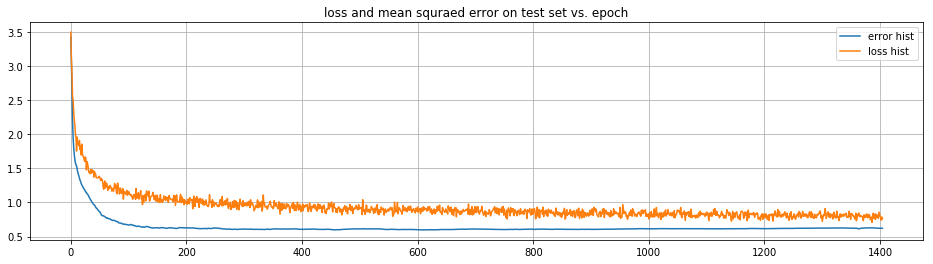

KeyboardInterrupt: 

<Figure size 1152x864 with 0 Axes>

In [60]:
EPOCHS = 100000
xy_test, theta_test = get_xy_and_theta_2(10000)
for i in range(EPOCHS):
    print("epoch {}".format(i))
    xy_train, theta_train = get_xy_and_theta_2(1024)
    history = model.fit(xy_train, xy_train, epochs=1, batch_size=32, verbose = 1)
    theta_pred = model.predict(xy_test)
    xy_pred = np.zeros((theta_pred.shape[0], 2))
    for j in range(theta_pred.shape[0]):
        a = get_positions_2(np.squeeze(theta_pred[j, :]))
        xy_pred[j, :] = a[1, :, 0]
    error = np.mean(np.square(xy_pred - xy_test))
    loss_hist.append(history.history['loss'][0])
    error_hist.append(error)
    clear_output()
    
    plt.figure(figsize=(16, 4))
    line1, = plt.plot(error_hist, label="error hist")
    line2, = plt.plot(loss_hist, label="loss hist")
    plt.grid()
    plt.title('loss and mean squraed error on test set vs. epoch')
    plt.legend((line1, line2), ('error hist', 'loss hist'))
    plt.show()

    xy_temp, theta_temp = get_xy_and_theta_2(12)
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            idx = j + i * 4
            theta = model.predict(np.reshape(xy_temp[idx], (1, 2)))
            
            
#             # for 1 segment arm
#             a = get_positions_1(np.squeeze(theta))
#             col.plot([0, a[0]], [0, a[1]])
#             col.plot(xy_temp[idx][0], xy_temp[idx][1], 'bo', markersize=10)
#             col.plot(a[0], a[1], 'ro', markersize=10)
#             col.set_xlim([-3, 3])
#             col.set_ylim([-3, 3])
            
            # for 2 segment arm
            a = get_positions_2(np.squeeze(theta))
            col.plot([0, a[0][0]], [0, a[0][1]])
            col.plot([a[0][0], a[1][0]], [a[0][1], a[1][1]])
            col.plot(xy_temp[idx][0], xy_temp[idx][1], 'bo', markersize=10)
            col.plot(a[1][0], a[1][1], 'ro', markersize=10)
            col.set_xlim([-3, 3])
            col.set_ylim([-3, 3])
            
#             # for 3 segment arm
#             col.plot([0, a[0][0]], [0, a[0][1]])
#             col.plot([a[0][0], a[1][0]], [a[0][1], a[1][1]])
#             col.plot([a[1][0], a[2][0]], [a[1][1], a[2][1]])
#             col.plot(xy_temp[idx][0], xy_temp[idx][1], 'bo', markersize=10)
#             col.plot(a[2][0], a[2][1], 'ro', markersize=10)
#             col.set_xlim([-3, 3])
#             col.set_ylim([-3, 3])
    plt.show()

In [30]:
model.save('model.h5')

In [31]:
np.save('loss_hist.npy', loss_hist)
np.save('error_hist.npy', error_hist)

In [ ]:
model.input

In [ ]:
num_test = 1000
xy_test = np.zeros((num_test, 2))
theta_test = np.zeros((num_test, 3))

theta_test[:,0] = (np.random.random((num_test)) * 2 * np.pi) - np.pi
theta_test[:,1] = (np.random.random((num_test)) * np.pi) - (0.5 * np.pi)
theta_test[:,2] = (np.random.random((num_test)) * 0.75 * np.pi) - (0.375 * np.pi)
for i in range(num_test):
    temp = forwardKinematics(theta_test[i,0], theta_test[i,1], theta_test[i,2])
    xy_test[i, :] = temp[:2]

In [ ]:
theta_pred = model.predict(xy_test)
num_pred = 200
xy_pred = np.zeros((num_pred, 2))
for i in range(num_pred):
    temp = forwardKinematics(theta_pred[i,0],theta_pred[i,1],theta_pred[i,2])
    xy_pred[i,:] = temp[:2]

In [ ]:
plt.figure(figsize=(30, 4))
plt.plot(xy_pred[:200, 0])
plt.plot(xy_test[:200, 0])

plt.figure(figsize=(30, 4))
plt.plot(xy_pred[:200, 1])
plt.plot(xy_test[:200, 1])

In [ ]:
scipy.io.savemat('c:/Users/jpeace2/Desktop/theta_pred.mat', mdict={'theta_pred': theta_pred})
scipy.io.savemat('c:/Users/jpeace2/Desktop/xy_test.mat', mdict={'xy_test': xy_test})
scipy.io.savemat('c:/Users/jpeace2/Desktop/xy_test.mat', mdict={'xy_test': theta})

In [ ]:
theta[0,:]